In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.6.0


## Hyperparameters

In [3]:
batch_size = 32
seq_len = 20

d_k = 256
d_v = 256
n_heads = 8
ff_dim = 128

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

## Load Samsung data

In [18]:
df = pd.read_csv('./data/preprocessed_kospi50_daily_stock_chart.csv')
df = df[df.name == "삼성전자"]
df.sort_values('date', inplace=True)
df_mv = df[["open", "high", "low", "close"]].rolling(10).mean()
df = pd.concat([df[["code", "name", "date"]], df_mv, 
                     df[["z_d5", "z_d10", "z_d15", "z_d20", "z_d25", "z_d30"]]], axis=1)
df.dropna(how='any', axis=0, inplace=True)
df

,code,name,date,open,high,low,close,z_d5,z_d10,z_d15,z_d20,z_d25,z_d30
167894,A005930,삼성전자,19800115,0.002492,0.020247,-0.022165,0.008129,0.069767,0.044186,0.044186,0.044186,0.044186,0.044186
167895,A005930,삼성전자,19800116,-0.002508,0.017520,-0.024437,0.010454,0.018182,0.029545,0.018595,0.018595,0.018595,0.018595
167896,A005930,삼성전자,19800117,0.002370,0.017520,-0.021782,0.010227,-0.013333,0.015556,-0.003704,-0.003704,-0.003704,-0.003704
167897,A005930,삼성전자,19800118,0.006865,0.019742,-0.023953,0.002910,-0.017778,0.017778,-0.003419,-0.003419,-0.003419,-0.003419
167898,A005930,삼성전자,19800119,0.004691,0.019742,-0.023953,0.000587,-0.030435,-0.004348,-0.023292,-0.023292,-0.023292,-0.023292
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179048,A005930,삼성전자,20210831,0.000796,0.010946,-0.009411,0.003425,-0.019817,-0.029335,-0.018861,0.002738,0.007927,0.011734
179049,A005930,삼성전자,20210901,0.000666,0.010389,-0.009500,0.003960,-0.018229,-0.026823,-0.023090,-0.001563,0.005729,0.009462
179050,A005930,삼성전자,20210902,0.001171,0.009663,-0.009895,0.004000,-0.004211,-0.012763,-0.015000,0.004408,0.014632,0.018991
179051,A005930,삼성전자,20210903,-0.000191,0.008143,-0.010403,0.005337,-0.006005,-0.015405,-0.023064,-0.007050,0.005431,0.009661


## Plot daily celltrion closing prices and volume

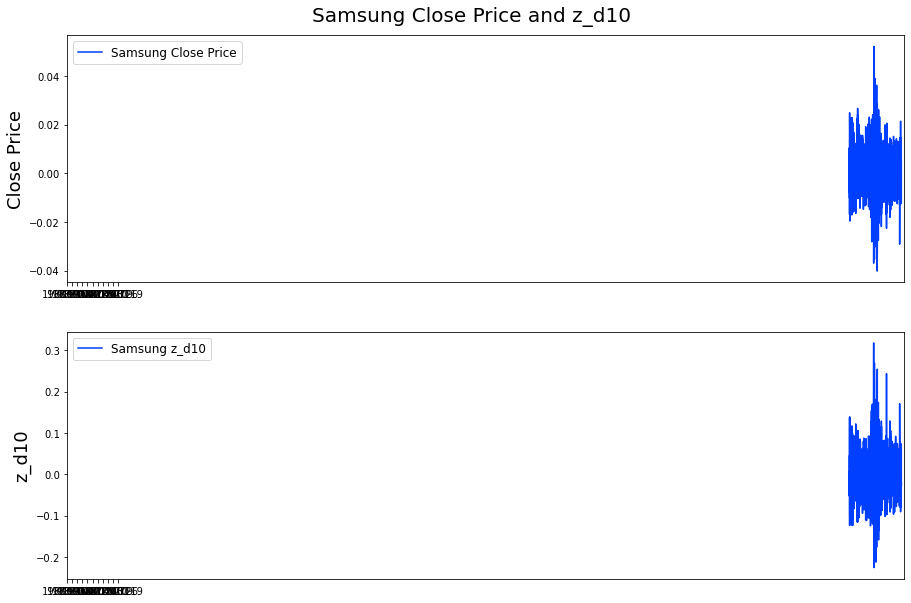

In [17]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Samsung Close Price and z_d10", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['close'], label='Samsung Close Price')
ax1.set_xticks(range(0, df.shape[0], 1100))
ax1.set_xticklabels(df['date'].loc[::1100])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['z_d10'], label='Samsung z_d10')
ax2.set_xticks(range(0, df.shape[0], 1100))
ax2.set_xticklabels(df['date'].loc[::1100])
ax2.set_ylabel('z_d10', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns

In [ ]:
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['code', 'name', 'date'], inplace=True)
df_val.drop(columns=['code', 'name', 'date'], inplace=True)
df_test.drop(columns=['code', 'name', 'date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (8935, 10)
Validation data shape: (1117, 10)
Test data shape: (1116, 10)


,open,high,low,close,z_d5,z_d10,z_d15,z_d20,z_d25,z_d30
0,0.050000,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.048780,0.00,-0.048780,0.025000,-0.012195,-0.012195,-0.012195,-0.012195,-0.012195,-0.012195
2,-0.022727,0.00,-0.022727,0.073171,-0.053030,-0.053030,-0.053030,-0.053030,-0.053030,-0.053030
3,0.000000,0.00,-0.021739,0.045455,-0.070652,-0.070652,-0.070652,-0.070652,-0.070652,-0.070652
4,-0.020833,0.00,-0.041667,0.043478,-0.087500,-0.087500,-0.087500,-0.087500,-0.087500,-0.087500


## Plot daily changes of close prices and volume

## Create chunks of training, validation and test data

In [ ]:
# Training data
X_train, y_train_1, y_train_3, y_train_7  = [], [], [], []
for i in range(seq_len, len(train_data)-7):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train_1.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
  y_train_3.append(train_data[:, 3][i+3]) #Value of 4th column (Close Price) of df-row 128+1+3
  y_train_7.append(train_data[:, 3][i+7]) #Value of 4th column (Close Price) of df-row 128+1+7
X_train, y_train_1, y_train_3, y_train_7 = np.array(X_train), np.array(y_train_1), np.array(y_train_3), np.array(y_train_7)

###############################################################################

# Validation data
X_val, y_val_1, y_val_3, y_val_7  = [], [], [], []
for i in range(seq_len, len(val_data)-7):
    X_val.append(val_data[i-seq_len:i])
    y_val_1.append(train_data[:, 3][i])
    y_val_3.append(train_data[:, 3][i+3])
    y_val_7.append(train_data[:, 3][i+7])
X_val, y_val_1, y_val_3, y_val_7 = np.array(X_val), np.array(y_val_1), np.array(y_val_3), np.array(y_val_7)


###############################################################################

# Test data
X_test, y_test_1, y_test_3, y_test_7  = [], [], [], []
for i in range(seq_len, len(test_data)-7):
    X_test.append(val_data[i-seq_len:i])
    y_test_1.append(train_data[:, 3][i])
    y_test_3.append(train_data[:, 3][i+3])
    y_test_7.append(train_data[:, 3][i+7])
X_test, y_test_1, y_test_3, y_test_7 = np.array(X_test), np.array(y_test_1), np.array(y_test_3), np.array(y_test_7)

print('Training set shape', X_train.shape, y_train_1.shape)
print('Validation set shape', X_val.shape, y_val_1.shape)
print('Testing set shape' ,X_test.shape, y_test_1.shape)

Training set shape (8898, 30, 10) (8898,)
Validation set shape (1080, 30, 10) (1080,)
Testing set shape (1079, 30, 10) (1079,)


## TimeVector

In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:10], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

In [ ]:
#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

In [ ]:
#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

In [ ]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 10))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model1 = create_model()
model3 = create_model()
model7 = create_model()
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 10)]     0                                            
__________________________________________________________________________________________________
time2_vector_1 (Time2Vector)    (None, 30, 2)        120         input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 30, 12)       0           input_2[0][0]                    
                                                                 time2_vector_1[0][0]             
__________________________________________________________________________________________________
transformer_encoder_3 (Transfor (None, 30, 12)       107720      concatenate_1[0][0]        

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint('Samsung_Transformer+TimeEmbedding_pred_1.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)

history = model1.fit(X_train, y_train_1,
                    batch_size=batch_size,
                    epochs=35,
                    callbacks=[callback],
                    validation_data=(X_val, y_val_1))

Epoch 1/35
279/279 [==============================] - 112s 330ms/step - loss: 6.2494e-04 - mae: 0.0176 - mape: 414068.6250 - val_loss: 6.7476e-04 - val_mae: 0.0188 - val_mape: 1065240.5000

Epoch 00001: val_loss improved from inf to 0.00067, saving model to Samsung_Transformer+TimeEmbedding_pred_1.hdf5
Epoch 2/35
279/279 [==============================] - 90s 322ms/step - loss: 6.1598e-04 - mae: 0.0174 - mape: 267899.4375 - val_loss: 6.7150e-04 - val_mae: 0.0186 - val_mape: 810392.5000

Epoch 00002: val_loss improved from 0.00067 to 0.00067, saving model to Samsung_Transformer+TimeEmbedding_pred_1.hdf5
Epoch 3/35
279/279 [==============================] - 88s 315ms/step - loss: 6.1565e-04 - mae: 0.0174 - mape: 202753.8125 - val_loss: 6.7425e-04 - val_mae: 0.0192 - val_mape: 1264819.6250

Epoch 00003: val_loss did not improve from 0.00067
Epoch 4/35
279/279 [==============================] - 89s 317ms/step - loss: 6.1563e-04 - mae: 0.0174 - mape: 276181.5625 - val_loss: 6.7098e-04 - val

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint('Samsung_Transformer+TimeEmbedding_pred_3.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)

history = model3.fit(X_train, y_train_3,
                    batch_size=batch_size,
                    epochs=35,
                    callbacks=[callback],
                    validation_data=(X_val, y_val_3))

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint('Samsung_Transformer+TimeEmbedding_pred_7.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)

history = model7.fit(X_train, y_train_7,
                    batch_size=batch_size,
                    epochs=35,
                    callbacks=[callback],
                    validation_data=(X_val, y_val_7))

Epoch 1/35
279/279 [==============================] - 75s 207ms/step - loss: 6.2225e-04 - mae: 0.0175 - mape: 313262.2812 - val_loss: 2.5805e-04 - val_mae: 0.0121 - val_mape: 23839.5762

Epoch 00001: val_loss improved from inf to 0.00026, saving model to Samsung_Transformer+TimeEmbedding3.hdf5
Epoch 2/35
279/279 [==============================] - 55s 196ms/step - loss: 6.1543e-04 - mae: 0.0174 - mape: 292227.0000 - val_loss: 2.5692e-04 - val_mae: 0.0120 - val_mape: 37295.6328

Epoch 00002: val_loss improved from 0.00026 to 0.00026, saving model to Samsung_Transformer+TimeEmbedding3.hdf5
Epoch 3/35
279/279 [==============================] - 54s 195ms/step - loss: 6.1466e-04 - mae: 0.0173 - mape: 203807.0781 - val_loss: 2.5872e-04 - val_mae: 0.0120 - val_mape: 74581.2656

Epoch 00003: val_loss did not improve from 0.00026
Epoch 4/35
279/279 [==============================] - 54s 194ms/step - loss: 6.1574e-04 - mae: 0.0174 - mape: 208425.5625 - val_loss: 2.6101e-04 - val_mae: 0.0121 - val

In [ ]:
model1 = tf.keras.models.load_model('./Samsung_Transformer+TimeEmbedding_pred_1.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


In [ ]:
model3 = tf.keras.models.load_model('./Samsung_Transformer+TimeEmbedding_pred_3.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


In [ ]:
model7 = tf.keras.models.load_model('./Samsung_Transformer+TimeEmbedding_pred_7.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


In [ ]:
model = model1
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred1 = model.predict(X_test[:700])
test_pred2 = model.predict(X_test[700:])

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train_1, verbose=0)
val_eval = model.evaluate(X_val, y_val_1, verbose=0)
test_eval1 = model.evaluate(X_test[:700], y_test_1[:700], verbose=0)
test_eval2 = model.evaluate(X_test[700:], y_test_1[700:], verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test1 Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval1[0], test_eval1[1], test_eval1[2]))
print('Test2 Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval2[0], test_eval2[1], test_eval2[2]))

 
Evaluation metrics
Training Data - Loss: 0.0006, MAE: 0.0171, MAPE: 22277.8359
Validation Data - Loss: 0.0007, MAE: 0.0179, MAPE: 57347.1992
Test1 Data - Loss: 0.0009, MAE: 0.0217, MAPE: 44463.7930
Test2 Data - Loss: 0.0003, MAE: 0.0110, MAPE: 81293.4688


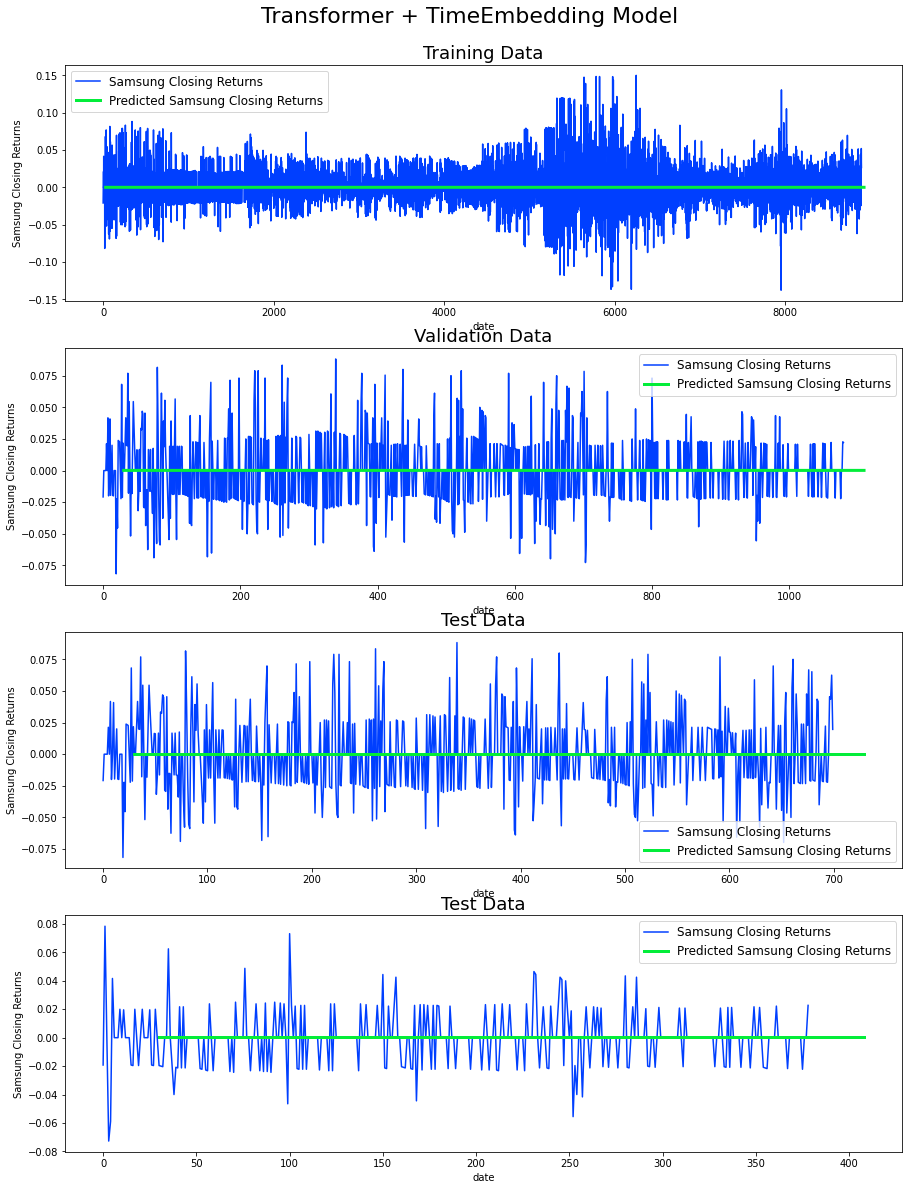

In [ ]:

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(411)
ax11.plot(y_train_1, label='Samsung Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Samsung Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('date')
ax11.set_ylabel('Samsung Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(412)
ax21.plot(y_val_1, label='Samsung Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Samsung Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('date')
ax21.set_ylabel('Samsung Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(413)
ax31.plot(y_test_1[:700], label='Samsung Closing Returns')
ax31.plot(np.arange(seq_len, test_pred1.shape[0]+seq_len), test_pred1, linewidth=3, label='Predicted Samsung Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('date')
ax31.set_ylabel('Samsung Closing Returns')
ax31.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(414)
ax31.plot(y_test_1[700:], label='Samsung Closing Returns')
ax31.plot(np.arange(seq_len, test_pred2.shape[0]+seq_len), test_pred2, linewidth=3, label='Predicted Samsung Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('date')
ax31.set_ylabel('Samsung Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Model metrics

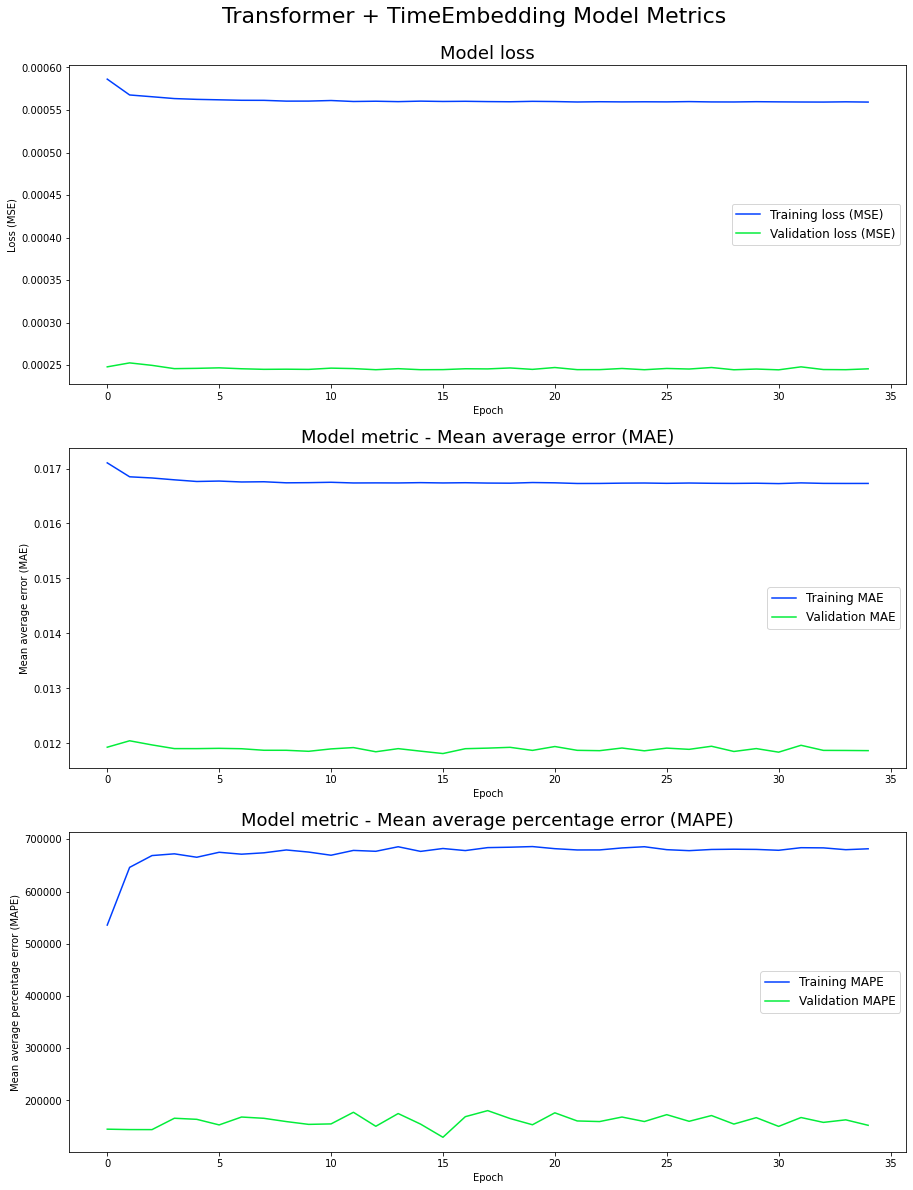

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="Samsung_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

NameError: ignored

# Moving Average

## Moving Average - Load IBM data again, to apply rolling window

In [ ]:
path = '/content/drive/MyDrive/programmers/project/data/celltrion-stock-data-2005-2021.csv'

df = pd.read_csv(path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'vol'])
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,Date,Open,High,Low,Close,Volume
9,20050801,4447.4,4590.9,4209.7,4334.9,72391.6
10,20050802,4347.5,4417.0,4113.5,4157.3,49530.5
11,20050803,4164.7,4241.6,4001.0,4044.8,29976.3
12,20050804,4061.1,4141.7,3950.7,4001.1,21748.4
13,20050805,3999.7,4082.5,3906.3,3958.2,19151.5


## Moving Average - Plot daily celltrion closing prices and volume

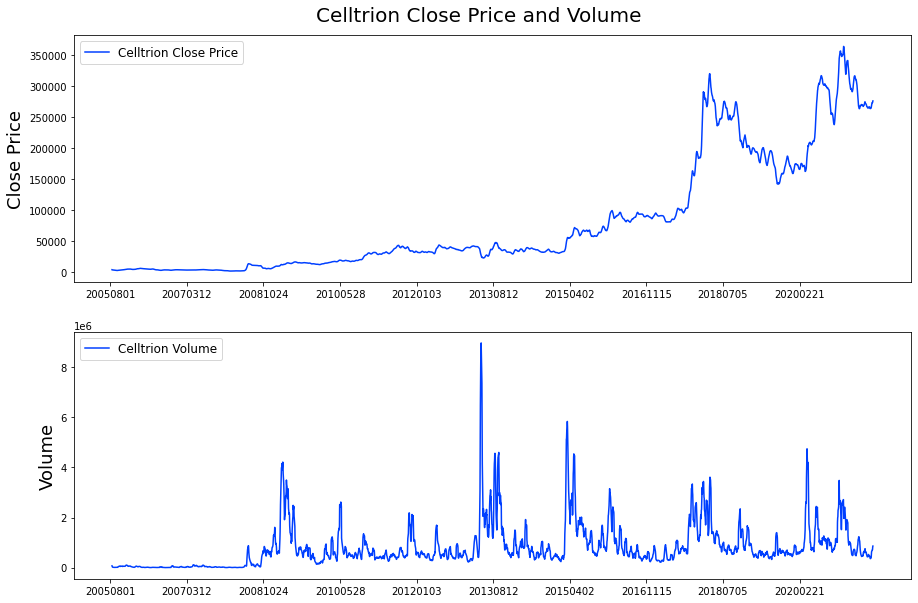

In [ ]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Celltrion Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='Celltrion Close Price')
ax1.set_xticks(range(0, df.shape[0], 400))
ax1.set_xticklabels(df['Date'].loc[::400])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='Celltrion Volume')
ax2.set_xticks(range(0, df.shape[0], 400))
ax2.set_xticklabels(df['Date'].loc[::400])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Moving Average - Calculate normalized percentage change for all columns

In [ ]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

df_train_y = df_train["Close"]
df_val_y = df_val["Close"]
df_test_y = df_test["Close"]

# Remove date column
df_train.drop(columns=['Date', 'Close'], inplace=True)
df_val.drop(columns=['Date', 'Close'], inplace=True)
df_test.drop(columns=['Date', 'Close'], inplace=True)

# Convert pandas columns into arrays
train_x = df_train.values
train_y = df_train_y.values
val_x = df_val.values
val_y = df_val_y.values
test_x = df_test.values
test_y = df_test_y.values

print('Training x shape: {}'.format(train_x.shape))
print('Training y shape: {}'.format(train_y.shape))

print('Validation x shape: {}'.format(val_x.shape))
print('Validation y shape: {}'.format(val_y.shape))

print('Test x shape: {}'.format(test_x.shape))
print('Test y shape: {}'.format(test_y.shape))

df_train.head()

Training x shape: (3180, 4)
Training y shape: (3180,)
Validation x shape: (397, 4)
Validation y shape: (397,)
Test x shape: (397, 4)
Test y shape: (397,)


,Open,High,Low,Volume
10,0.224260,0.150961,0.222408,0.102369
11,0.131145,0.142256,0.201027,0.076880
12,0.212786,0.219078,0.271284,0.115702
13,0.259174,0.263098,0.277624,0.165742
14,0.273880,0.257804,0.272513,0.160908


## Moving Average - Plot daily changes of close price and volume

## Moving Average - Create chunks of training, validation, and test data

In [ ]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_x)):
  X_train.append(train_x[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_y[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_x)):
    X_val.append(val_x[i-seq_len:i])
    y_val.append(val_y[i-seq_len:i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_x)):
    X_test.append(test_x[i-seq_len:i])
    y_test.append(test_y[i-seq_len:i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)





Training set shape (3170, 10, 4) (3170, 10)
Validation set shape (387, 10, 4) (387, 10)
Testing set shape (387, 10, 4) (387, 10)


## Moving Average - Model

In [ ]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 4))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
time2_vector_3 (Time2Vector)    (None, 10, 2)        40          input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 10, 6)        0           input_3[0][0]                    
                                                                 time2_vector_3[0][0]             
__________________________________________________________________________________________________
transformer_encoder_9 (Transfor (None, 10, 6)        29348       concatenate_2[0][0]        

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint('Celltrion_Transformer+TimeEmbedding_mv4.hdf5',
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=30,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

Epoch 1/30
100/100 [==============================] - 12s 119ms/step - loss: 0.0188 - mae: 0.0929 - mape: 27.6972 - val_loss: 0.0013 - val_mae: 0.0298 - val_mape: 8.7735

Epoch 00001: val_loss improved from inf to 0.00132, saving model to Celltrion_Transformer+TimeEmbedding_mv4.hdf5
Epoch 2/30
100/100 [==============================] - 8s 85ms/step - loss: 0.0026 - mae: 0.0336 - mape: 10.3538 - val_loss: 0.0017 - val_mae: 0.0356 - val_mape: 10.6068

Epoch 00002: val_loss did not improve from 0.00132
Epoch 3/30
100/100 [==============================] - 8s 84ms/step - loss: 0.0019 - mae: 0.0304 - mape: 9.4039 - val_loss: 6.9415e-04 - val_mae: 0.0211 - val_mape: 6.8656

Epoch 00003: val_loss improved from 0.00132 to 0.00069, saving model to Celltrion_Transformer+TimeEmbedding_mv4.hdf5
Epoch 4/30
100/100 [==============================] - 8s 85ms/step - loss: 0.0017 - mae: 0.0285 - mape: 8.8785 - val_loss: 5.1866e-04 - val_mae: 0.0177 - val_mape: 5.6036

Epoch 00004: val_loss improved fro

In [ ]:
model = tf.keras.models.load_model('./Celltrion_Transformer+TimeEmbedding_mv4.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0009, MAE: 0.0204, MAPE: 6.2803
Validation Data - Loss: 0.0005, MAE: 0.0169, MAPE: 5.2247
Test Data - Loss: 0.0007, MAE: 0.0189, MAPE: 5.6419


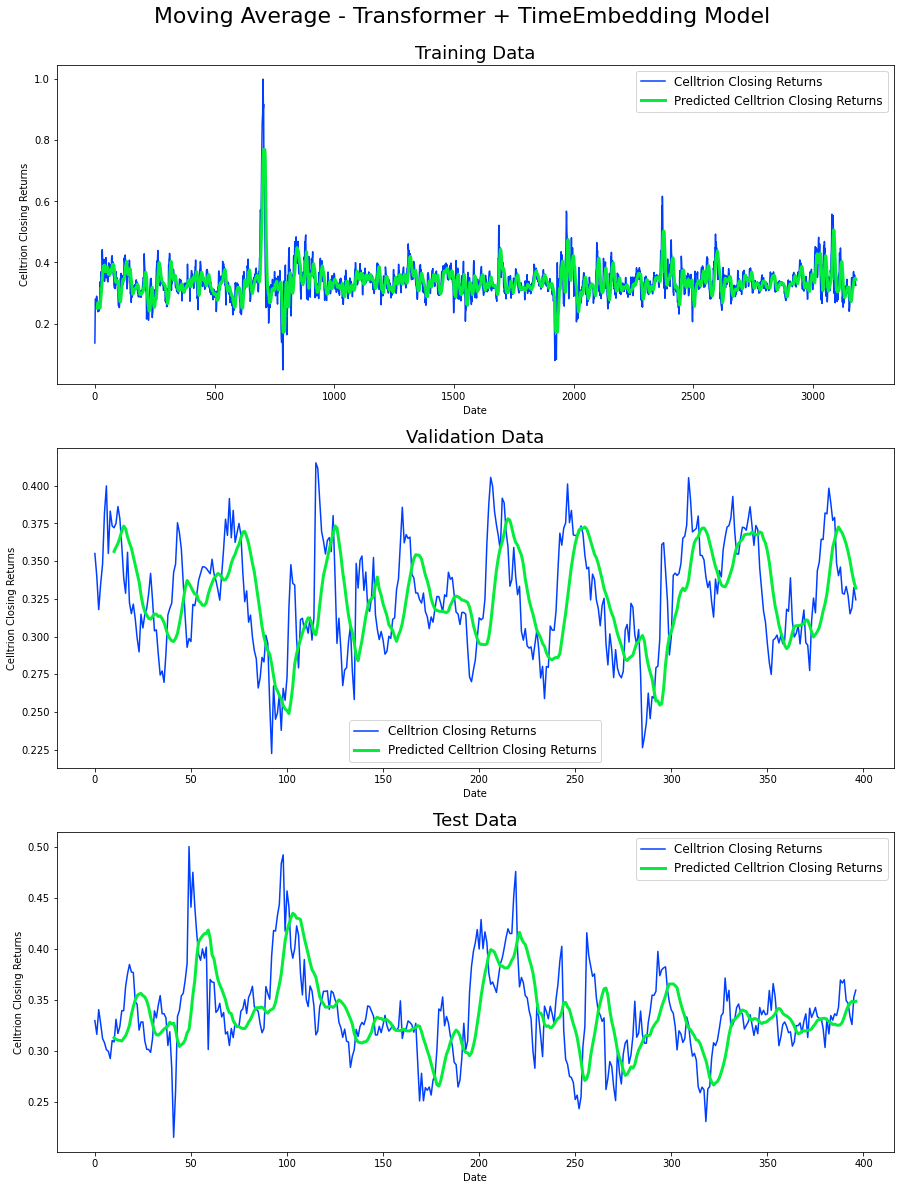

In [ ]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_y, label='Celltrion Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Celltrion Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Celltrion Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_y, label='Celltrion Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Celltrion Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Celltrion Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_y, label='Celltrion Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Celltrion Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Celltrion Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Moving Average - Model metrics

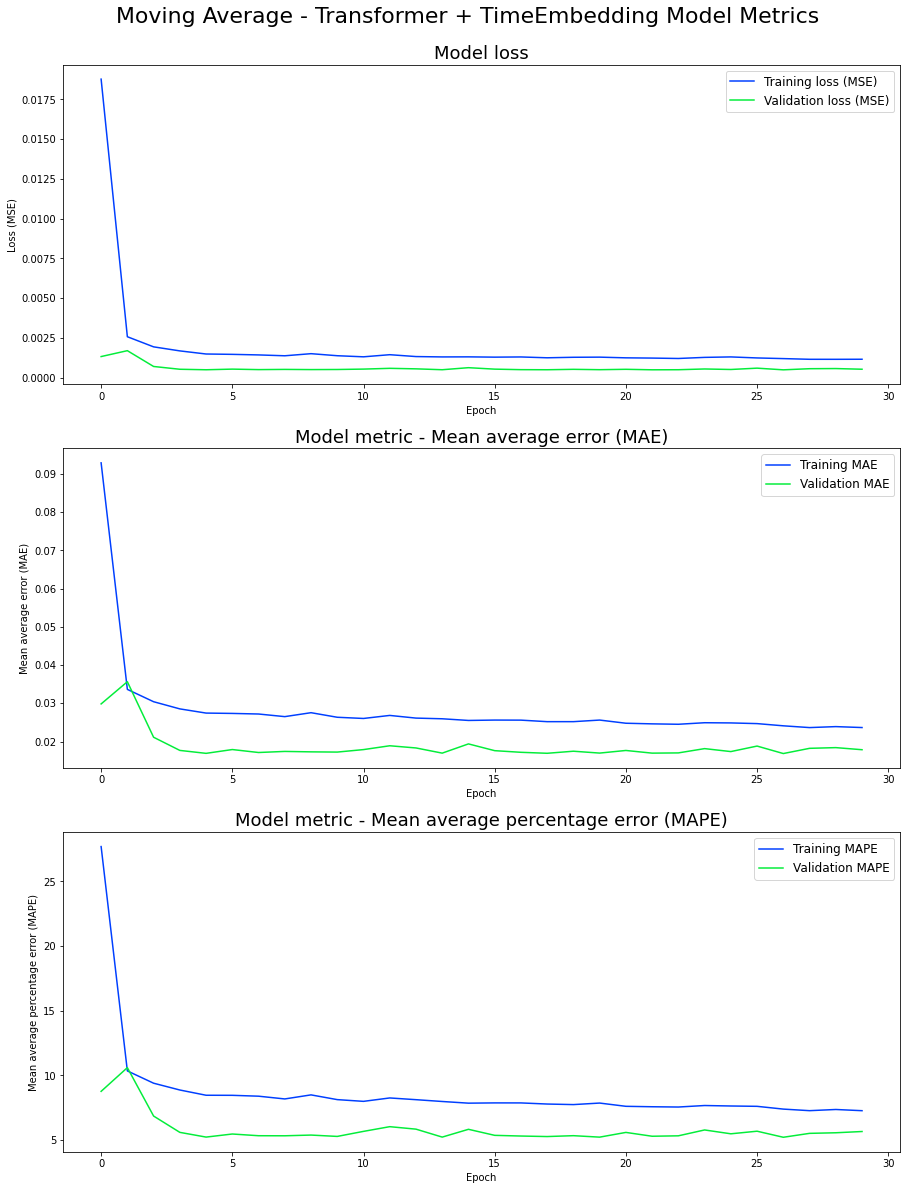

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)